========== Loading training and testing finished =========
./2002/07/26/big/img_634.jpg
./2002/08/09/big/img_806.jpg
./2002/07/24/big/img_106.jpg
./2002/07/19/big/img_523.jpg
./2002/08/02/big/img_666.jpg
./2003/01/14/big/img_830.jpg


D:\Anaconda\envs\ldy\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


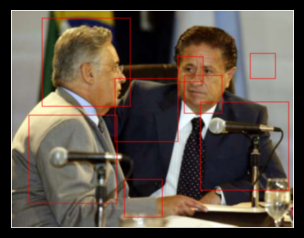

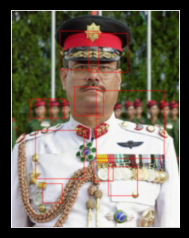

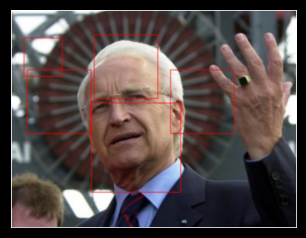

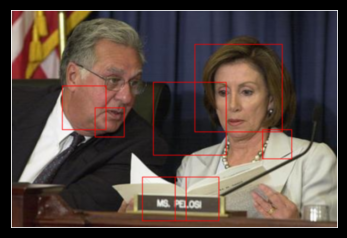

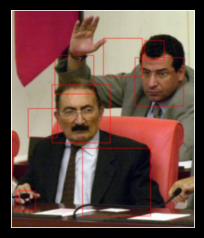

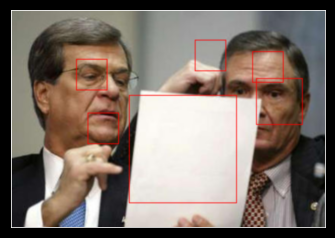

In [1]:
'''
This is the file for performing simple face detection:
    1. train corresponding classfier
    2. bounded box proposal 
    3. Merge bounded box
    4. Draw bounded box 
'''
import sys, os
sys.path.append("./")
from Utils.DataLoader import DataLoader
from Models.LogisticModel import LogisticRegression
from Models.FisherModel import FisherModel
from Models.SVM_Model import SVM
from Models.CNN_Model import VanillaCNN
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import cv2

FOLD_NAME = "./FDDB-folds/FDDB-fold-09.txt"
image_names = open(FOLD_NAME, "r").readlines()
image_names = [os.path.join("./", name.strip()+".jpg") for name in image_names]

Data = DataLoader()
Data.load_pickle_dataset_new()

def extract_hog_feature(image):
    hog_feature = hog(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    return hog_feature

def generate_proposals(width, height):
    '''
    One proposal is [(top_left_x, top_left_y), (bottom_right_x, bottom_right_y)]
    '''
    proposals = []
    for size in range(40, 160, 20):
        step = max(int(size/20), 5)
        for i in range(0, width - size, step):
            for j in range(0, height - size, step):
                top_left = (i, j)
                bot_right = (i+size, j+size)
                proposals.append([top_left, bot_right])
    return proposals

def draw_bounded_box(img, bounded_boxes):
    for (top_left, bot_right) in bounded_boxes:
        img = cv2.rectangle(img,top_left,bot_right,(255,0,0),1)
    return img

def face_detection(image, classfier = ""):
    rgr_model = LogisticRegression()
    rgr_model.fit_RGD(Data.train_data, Data.train_label)
    rgr_model.test_acc(Data.test_data, Data.test_label)

    orig_width = image.shape[1]
    orig_height = image.shape[0]

    proposals = generate_proposals(orig_width, orig_height)

    bounded_boxes = []
    for tmp_bounded_box in proposals:
        top_left = tmp_bounded_box[0]
        bot_right = tmp_bounded_box[1]
        tmp_img = image[top_left[1]:bot_right[1], top_left[0]:bot_right[0]]

        if rgr_model.predict(tmp_img):
            bounded_boxes.append(tmp_bounded_box)

    detected_image = draw_bounded_box(image, bounded_boxes)

    # ended
    plt.imshow(detected_image, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def merge_bounded_boxes(bounded_boxes, probas,  threshold = 0.5):
    sorted_probas = sorted(probas)
    sorted_bounded_boxes = []
    for proba in sorted_probas:
        sorted_bounded_boxes.append(bounded_boxes[probas.index(proba)])
    bounded_boxes = sorted_bounded_boxes

    results_boxes = []
    while(len(bounded_boxes)>0):
        tmp_bounded_box = bounded_boxes[-1]
        tmp_top_left = tmp_bounded_box[0]
        tmp_bot_right = tmp_bounded_box[1]
        tmp_square = abs((tmp_bot_right[0] - tmp_top_left[0]) * (tmp_bot_right[1] - tmp_top_left[1]))
        
        deleted = []
        for i in range(len(bounded_boxes)-1):
            compare_top_left = bounded_boxes[i][0]
            compare_bot_right = bounded_boxes[i][1]
            
            # Check whether overlap
            if (tmp_top_left[0] > compare_bot_right[0] or tmp_top_left[1] > compare_bot_right[1]) \
            or (tmp_bot_right[0] < compare_top_left[0] or tmp_bot_right[1] < compare_top_left[1]):
                continue

            compare_square = abs((compare_bot_right[0] - compare_top_left[0]) * (compare_bot_right[1] - compare_top_left[1]))

            overlap_top_left_x = max(tmp_top_left[0], compare_top_left[0])
            overlap_top_left_y = max(tmp_top_left[1], compare_top_left[1])
            overlap_bot_right_x = min(tmp_bot_right[0], compare_bot_right[0])
            overlap_bot_right_y = min(tmp_bot_right[1], compare_bot_right[1])
            overlap_square = abs((overlap_bot_right_x - overlap_top_left_x)*(overlap_bot_right_y-overlap_top_left_y))

            rate = max(overlap_square/compare_square, overlap_square/tmp_square)
            if rate > threshold:
                deleted.append(bounded_boxes[i])
                # tmp_top_left = (min(tmp_top_left[0], compare_top_left[0]), min(tmp_top_left[1], compare_top_left[1]))
                # tmp_bot_right = (max(tmp_bot_right[0], compare_bot_right[0]), max(tmp_bot_right[1], compare_bot_right[1]))
                # tmp_square = (tmp_bot_right[0] - tmp_top_left[0]) * (tmp_bot_right[1] - tmp_top_left[1])
                # tmp_bounded_box = [tmp_top_left, tmp_bot_right]
        bounded_boxes.remove(bounded_boxes[-1])
        for tmp in deleted:
            bounded_boxes.remove(tmp)
        results_boxes.append(tmp_bounded_box)
    return results_boxes

'''
./2002/07/22/big/img_43.jpg
./2002/08/18/big/img_484.jpg
./2002/07/26/big/img_678.jpg
./2002/08/13/big/img_717.jpg
./2002/08/26/big/img_422.jpg
./2003/01/16/big/img_915.jpg
./2003/01/17/big/img_620.jpg
./2002/08/14/big/img_325.jpg
./2002/08/14/big/img_116.jpg
./2002/07/31/big/img_593.jpg
./2002/08/15/big/img_549.jpg
'''
if __name__ == "__main__": 
    from sklearn.linear_model import LogisticRegression
    rgr_model = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='multinomial').fit(Data.train_data_hog, Data.train_label)

    # file_name = "./2002/07/31/big/img_593.jpg"
for (i, file_name) in enumerate(image_names):
    if i % 50 == 1:
        print(file_name)

        image = cv2.imread(file_name)
        b, g, r = cv2.split(image)
        image = cv2.merge([r,g,b])

        orig_width = image.shape[1]
        orig_height = image.shape[0]

        proposals = generate_proposals(orig_width, orig_height)

        bounded_boxes = []
        probas = []
        for tmp_bounded_box in proposals:
            top_left = tmp_bounded_box[0]
            bot_right = tmp_bounded_box[1]
            tmp_img = image[top_left[1]:bot_right[1], top_left[0]:bot_right[0]]
            tmp_img = cv2.resize(tmp_img, (96, 96))

            tmp_hog = [extract_hog_feature(tmp_img)]
            tmp_hog = np.array(tmp_hog)

            proba = rgr_model.predict_proba(tmp_hog)[0][1]
            if proba > 0.8:
                bounded_boxes.append(tmp_bounded_box)
                probas.append(proba)

        bounded_boxes = merge_bounded_boxes(bounded_boxes, probas, threshold=0.3)
        detected_image = draw_bounded_box(image, bounded_boxes)

        # ended
        plt.imshow(detected_image, cmap = 'gray', interpolation = 'bicubic')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show() 
        